# Supplementary material: "Novel symbiotic genome-scale model reveals Wolbachia's arboviral pathogen blocking mechanism in _Aedes aegypti_"
Reproduction of results

# Imports, load model and function definitions

In [1]:
import cobra
from cobra import Reaction, Metabolite
from cobra import flux_analysis
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import find_blocked_reactions
#from cobra.flux_analysis import sample

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import math
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
%matplotlib inline

In [2]:
model = cobra.io.read_sbml_model('SymbioticTransformedmBioVALIDIDs.xml') 


--------------------------------------------
--------------------------------------------

Using license file /Users/natjimenez/gurobi.lic
Academic license - for non-commercial use only


In [37]:
def setMedia(model, boundAA = 0.07 ):
    #Defines growth media constraints based on a value valid for all amino acids, additionally it closes
    #riboflavin transport (to be supplied by Wolbachia)

    rxn = model.reactions.get_by_id('EX_phe_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA

    rxn = model.reactions.get_by_id('EX_ribflv_LPAREN_e_RPAREN_')
    rxn.lower_bound = 0
    rxn.upper_bound = 0

    rxn = model.reactions.get_by_id('EX_arg_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA

    rxn = model.reactions.get_by_id('EX_trp_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA


    rxn = model.reactions.get_by_id('EX_val_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA

    rxn = model.reactions.get_by_id('EX_tre_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA

    rxn = model.reactions.get_by_id('EX_ile_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA
    rxn = model.reactions.get_by_id('EX_leu_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA
    rxn = model.reactions.get_by_id('EX_met_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA

    rxn = model.reactions.get_by_id('EX_his_L_LPAREN_e_RPAREN_')
    rxn.lower_bound = -boundAA
    rxn.upper_bound = boundAA


    rxn = model.reactions.get_by_id('EX_chol_LPAREN_e_RPAREN_')
    rxn.lower_bound = -1
    rxn.upper_bound = 1

    rxn = model.reactions.get_by_id('EX_tre_LPAREN_e_RPAREN_')
    rxn.lower_bound = -10
    rxn.upper_bound = 10

    sol = model.optimize()
    model.summary()

    return model

# Model set up and constraints
Limits ammount of Riboflavin to be produced by Wolbachia

In [38]:
model = setMedia(model)

wolbachia_ribflv = model.problem.Constraint(
    model.reactions.RIBFLVt2w.flux_expression-1.183e-07*model.reactions.biomass_wolbachia.flux_expression,
    lb=-100,ub=0) #era -07
model.add_cons_vars(wolbachia_ribflv)
model.solver.update()

## "Pareto" growth curve and sampling
a. Pareto front between _Wolbachia_ and _Aedes aegypti_. Dots represent feasible solutions of the model after sampling 20,000 feasible solutions in terms of their cell growth rate


In [41]:
#Define wolbachia minimum growth grid
wolBio = np.linspace(0.0001,0.13,100)
bioW = model.reactions.get_by_id('biomass_wolbachia')
solmB = [] #biomass mosquito
model.objective = 'biomass_reaction'


solo2 = [] #o2
solribflvW = [] #riboflavin from wolbachia
solthm = [] #thiamine
solfol = []
solchsterol = []

#Amino acids
#EX_leu_L_LPAREN_e_RPAREN_
#r1557 #ile
#r1554 #val
solLeu = []
solIle = []
solVal = []
for wB in wolBio:
#for wB in mosBio:
    bioW.lower_bound = wB
    bioW.upper_bound = wB
    #print wB
    #bioM.lower_bound = wB
    #bioM.upper_bound = wB
    
    try:
        sol = model.optimize()
        #print model.summary()
        #if sol['bioT'] > 0:
        if sol['biomass_reaction'] > 0:
            solmB.append(sol['biomass_reaction'])
#             #solwB.append(sol['bioT'])
            solo2.append(sol['EX_o2_LPAREN_e_RPAREN_'])
            solribflvW.append(sol['RIBFLVt2w'])
            solthm.append(sol['EX_thm_LPAREN_e_RPAREN_'])
            solfol.append(sol['EX_fol_LPAREN_e_RPAREN_'])
            solchsterol.append(sol['EX_chsterol_LPAREN_e_RPAREN_'])
            
            solLeu.append(sol['EX_leu_L_LPAREN_e_RPAREN_'])
            solIle.append(sol['r1557'])
            solVal.append(sol['r1554'])
#             #print model.metabolites.ribflv_c.summary(threshold = 0)
#             #print sol['rxn05645_c0']-1.183e-11*sol['bioT']
            
            
        else: 
            solmB.append(0)
            #solwB.append(0)
            solo2.append(0)
            solribflvW.append(0)
            solthm.append(0)
            solfol.append(0)
            solchsterol.append(0)
            
            solLeu.append(0)
            solIle.append(0)
            solVal.append(0)
    except:
        #solmB = -1
        print(wB)
        solmB.append(-1)
        #solwB.append(-1)


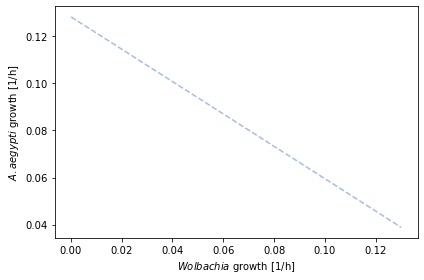

-2.5128520629003623


In [42]:
fig, ax1 = plt.subplots()

#ax1.plot(solwB,mosBio,label='Wolbachia', color='firebrick')
ax1.plot(wolBio, solmB,label='Wolbachia', linestyle='--', color='#a6bddb')#, color='firebrick')
#plt.scatter(wolBio,solmB,marker='.')
ax1.set_xlabel('$\it{Wolbachia}$ growth [1/h]') #,fontsize=18
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('$\it{A. aegypti}$ growth [1/h]')#, color='firebrick') #, fontsize=18
ax1.tick_params('y')#, colors='firebrick')
fig.tight_layout()
plt.show()

#fig.savefig('paretoMosWol.pdf')

wolPar = wolBio #Para graficar curva con sampling
mosPar = solmB

slope, intercept = np.polyfit(np.log(mosPar), np.log(wolPar), 1)
print(slope)

Loading sampling results generated in sampling section of this notebook

In [43]:
scsv = pd.read_csv('20181112csamplingSymbioticUnconstrained.csv')
bioM = scsv['biomass_reaction']
bioW = scsv['bioT']
bioMS = bioM
bioWS = bioW

20000


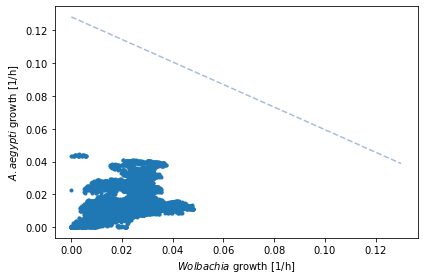

In [44]:
print(len(bioMS))
fig, ax1 = plt.subplots()
plt.scatter(bioWS, bioMS, marker='.') #(x,y)


ax1.plot(wolPar, mosPar,label='Wolbachia', linestyle='--', color='#a6bddb')
ax1.set_xlabel('$\it{Wolbachia}$ growth [1/h]')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('$\it{A. aegypti}$ growth [1/h]')


fig.tight_layout()
plt.show()
#fig.savefig('paretoMosWol.pdf')


20000
8510.489086686015
9.6084914989909
9.6084914989909
3.2573301729921256


/opt/anaconda3/envs/pareto/lib/python3.6/site-packages/pandas/core/series.py:679 RuntimeWarning: overflow encountered in float_power
/opt/anaconda3/envs/pareto/lib/python3.6/site-packages/ipykernel_launcher.py:46 UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


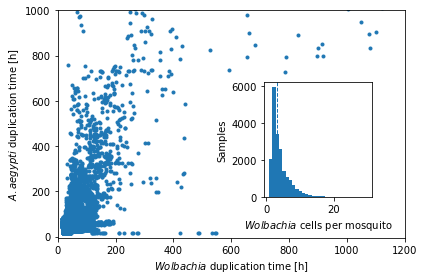

In [45]:
tdMS = np.true_divide(math.log(2),bioMS)
tdWS= np.true_divide(math.log(2),bioW)
#tdMS = math.log(2)/bioMS
#tdWS = math.log(2)/bioW

print(len(bioMS))
fig, ax1 = plt.subplots()
plt.scatter(tdWS, tdMS, marker='.') #(x,y)
plt.xlabel('Wolbachia biomass')#, fontsize=18)
plt.ylabel('Mosquito biomass')#, fontsize=18)

#ax1.plot(math.log(2)/wolPar, math.log(2)/mosPar,label='Wolbachia', linestyle='--', color='#a6bddb')#, color='firebrick')
ax1.set_xlabel('$\it{Wolbachia}$ duplication time [h]') #,fontsize=18
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('$\it{A. aegypti}$ duplication time [h]')
#ax1.set_ylim(bottom=None, top=200000, emit=True, auto=False, ymin=-5000, ymax=100000)
ax1.set_xlim(xmin=0, xmax=1200)
#ax1.set_ylim(bottom=None, top=200000, emit=True, auto=False, ymin=-5, ymax=1000)
ax1.set_ylim(bottom=None, emit=True, auto=False, ymin=-5, ymax=1000)
#ax1.tick_params('y')


with np.errstate(divide='ignore'):
    np.float64(1.0) / 0.0

divide = np.true_divide(tdMS,tdWS)

#wolperMos = np.array(wolperMos, dtype=np.float128)
wolperMos = np.float_power(2,divide)

forAvg = wolperMos[wolperMos<10000]

print(np.amax(forAvg))
#forAvg = wolperMos
print(np.average(forAvg))
print(forAvg.mean())
print(np.median(forAvg))
sub_axes = plt.axes([.62, .3, .25, .4]) 
n, bins, patches = sub_axes.hist(wolperMos,bins =30, range=(0.8, 30))

plt.axvline(np.median(forAvg), linestyle='dashed', linewidth=1)
plt.xlabel('$\it{Wolbachia}$ cells per mosquito')#, fontsize=18)
plt.ylabel('Samples')#, fontsize=18)


fig.tight_layout()
plt.show()
#fig.savefig('paretoMosWolTd.pdf')

## Amino acids, carbon sources and lipids consumed by Wolbachia

This analysis shows how much of the amino acids and lipids consumed by _Aedes aegypti_ are used as components of _Wolbachia pipientis_ biomass. The results are presented in fractions of transport of these metabolites into _Wolbachia_ divided by total exchange reactions of the whole system composed by both organisms.

In [46]:
def solToPlot(sol):
    glyc3p =  sol['rxn05578w']/abs(sol['GLYC3Ptmc']+abs(sol['GLYC3Ptmc'])+abs(sol['G3PD1']))
    arg = sol['ALP1w']/sol['EX_arg_L_LPAREN_e_RPAREN_'] #Transporte de argininaa
    ile = sol['AGP1_6w']/sol['EX_ile_L_LPAREN_e_RPAREN_']
    leu = sol['AGP1_7w']/sol['EX_leu_L_LPAREN_e_RPAREN_']
    lys = sol['GAP1_20w']/sol['EX_lys_L_LPAREN_e_RPAREN_']
    met = sol['AGP1_8w']/sol['EX_met_L_LPAREN_e_RPAREN_']
    phe = sol['AGP1_9w']/sol['EX_phe_L_LPAREN_e_RPAREN_']
    thr = sol['AGP1_13w']/sol['EX_thr_L_LPAREN_e_RPAREN_']
    trp = sol['BAP2_6w']/sol['EX_trp_L_LPAREN_e_RPAREN_']
    val = sol['AGP1_11w']/sol['EX_val_L_LPAREN_e_RPAREN_']
    chsterol = sol['lipidWTr']*0.2/sol['EX_chsterol_LPAREN_e_RPAREN_']
    clpn = sol['lipidWTr']*0.6/sol['CLS_hs']   
    pe = sol['lipidWTr']*1.59/abs(sol['CEPTE']+sol['PE_HStm'])
    ps = sol['lipidWTr']*0.18/sol['RE3301C']*-1

    
    toPlot = (glyc3p, arg , ile , leu , lys , met ,  phe, thr , trp  , val, chsterol, clpn, pe, ps)
    return toPlot
def toPlotLD(sol):
    ##To lipid droplets
    chsterol_ld = sol['sink_chsterolW']/sol['EX_chsterol_LPAREN_e_RPAREN_']
    clpn_ld = sol['sink_clpnW']/sol['CLS_hs']
    pe_ld = sol['sink_peW']/abs(sol['CEPTE']+sol['PE_HStm'])
    ps_ld = sol['sink_psW']/sol['RE3301C']*-1
    
    toPlot =(chsterol_ld, clpn_ld, pe_ld, ps_ld )
    return toPlot

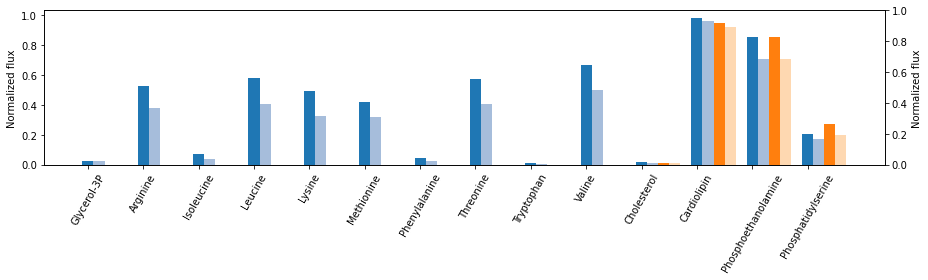

In [47]:
fixedMosBio = 0.01

rxn = model.reactions.get_by_id('biomass_reaction')
rxn.upper_bound = fixedMosBio
rxn.lower_bound = fixedMosBio

fixedWolPerMos = 1
rxn = model.reactions.get_by_id('biomass_wolbachia')
rxn.lower_bound = fixedMosBio*fixedWolPerMos #era 0.05
rxn.upper_bound = fixedMosBio*fixedWolPerMos  # era 0.015


sol = model.optimize()

#flux variability analysis
bar_width = 0.2
#means_wol1 = (glyc3p, arg , ile , leu , lys , met ,  phe, thr , trp  , val, chsterol, clpn, pe, ps)
    
means_wol1 = solToPlot(sol)
n_groups = len(means_wol1)
means_ld1 =toPlotLD(sol)

plotld1 = np.zeros_like(means_wol1)
plotld1[-len(means_ld1):] = means_ld1



fixedWolPerMos = 2
rxn = model.reactions.get_by_id('biomass_wolbachia')
rxn.lower_bound = fixedMosBio*fixedWolPerMos #era 0.05
rxn.upper_bound = fixedMosBio*fixedWolPerMos  # era 0.015


sol = model.optimize()
#model.summary()

#print(sol['bioT'])

means_ld2 =toPlotLD(sol)
plotld2 = np.zeros_like(means_wol1)
plotld2[-len(means_ld1):] = means_ld2


means_wol2 = solToPlot(sol)

fig, ax = plt.subplots(figsize=(13,4))

index = np.arange(n_groups)

error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_wol2, bar_width,
                color='#1f77b4')#, label='Exchange'

rects2 = ax.bar(index+bar_width, means_wol1, bar_width,
                color='#a6bddb') #,label='Wolbachia')

ld2 = ax.bar(index+2*bar_width, plotld2, bar_width,
                color='#ff7f0e') #,label='Wolbachia')
ld1 = ax.bar(index+3*bar_width, plotld1, bar_width,
                color='#fed8b1') #,label='Wolbachia')



ax.set_ylabel('Normalized flux')
ax.set_xticks(index)
ax.set_xticklabels(('Glycerol-3P','Arginine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine','Threonine','Tryptophan','Valine', 'Cholesterol', 'Cardiolipin','Phosphoethanolamine','Phosphatidylserine'), rotation='60')

ax2 = ax.twinx()

ax2.set_ylabel('Normalized flux')

#ax2.set_ylim(ymax=4.2*y2max)

#ax.legend()
plt.ylim(top=1)
fig.tight_layout()
plt.show()
#fig.savefig('AAExchange2020.pdf')

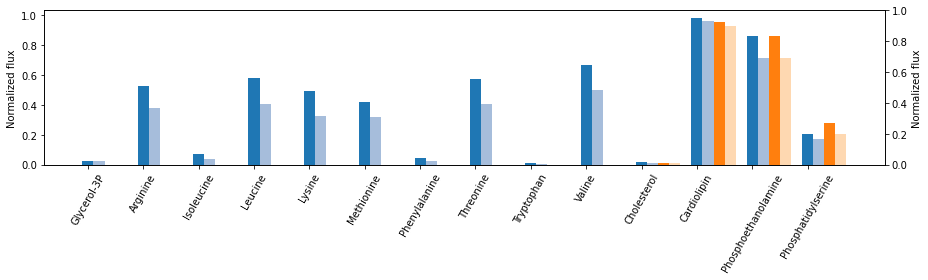

In [48]:
fixedMosBio = 0.01

rxn = model.reactions.get_by_id('biomass_reaction')
rxn.upper_bound = fixedMosBio
rxn.lower_bound = fixedMosBio

fixedWolPerMos = 1
rxn = model.reactions.get_by_id('biomass_wolbachia')
rxn.lower_bound = fixedMosBio*fixedWolPerMos #era 0.05
rxn.upper_bound = fixedMosBio*fixedWolPerMos  # era 0.015


sol = model.optimize()

#flux variability analysis
bar_width = 0.2
#means_wol1 = (glyc3p, arg , ile , leu , lys , met ,  phe, thr , trp  , val, chsterol, clpn, pe, ps)
    
means_wol1 = solToPlot(sol)
n_groups = len(means_wol1)
means_ld1 =toPlotLD(sol)

plotld1 = np.zeros_like(means_wol1)
plotld1[-len(means_ld1):] = means_ld1



fixedWolPerMos = 2
rxn = model.reactions.get_by_id('biomass_wolbachia')
rxn.lower_bound = fixedMosBio*fixedWolPerMos #era 0.05
rxn.upper_bound = fixedMosBio*fixedWolPerMos  # era 0.015


sol = model.optimize()
#model.summary()

#print(sol['bioT'])

means_ld2 =toPlotLD(sol)
plotld2 = np.zeros_like(means_wol1)
plotld2[-len(means_ld1):] = means_ld2


means_wol2 = solToPlot(sol)

fig, ax = plt.subplots(figsize=(13,4))

index = np.arange(n_groups)

error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_wol2, bar_width,
                color='#1f77b4')#, label='Exchange'

rects2 = ax.bar(index+bar_width, means_wol1, bar_width,
                color='#a6bddb') #,label='Wolbachia')

ld2 = ax.bar(index+2*bar_width, plotld2, bar_width,
                color='#ff7f0e') #,label='Wolbachia')
ld1 = ax.bar(index+3*bar_width, plotld1, bar_width,
                color='#fed8b1') #,label='Wolbachia')



ax.set_ylabel('Normalized flux')
ax.set_xticks(index)
ax.set_xticklabels(('Glycerol-3P','Arginine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine','Threonine','Tryptophan','Valine', 'Cholesterol', 'Cardiolipin','Phosphoethanolamine','Phosphatidylserine'), rotation='60')

ax2 = ax.twinx()

ax2.set_ylabel('Normalized flux')

#ax2.set_ylim(ymax=4.2*y2max)

#ax.legend()
plt.ylim(top=1)
fig.tight_layout()
plt.show()
#fig.savefig('AAExchange2020.pdf')

# Simulation of viral infection

Composition of a viral particle based on Zika virus amino acid composition and lipid composition.

In [49]:

rxn = model.reactions.get_by_id('biomass_wolbachia')
rxn.lower_bound = 0 
rxn.upper_bound = 1000

rxn = model.reactions.get_by_id('biomass_reaction')
rxn.upper_bound = 1000
rxn.lower_bound = 0

In [50]:
model.remove_reactions(list(['ZIKV']))
virusRxn = '0.3226951 ala_L_c + 0.224474 arg_L_c + 0.1196816 asn_L_c + 0.1870786 asp_L_c + 16.555468 atp_c + 0.1558894 ctp_c + 0.0982461 cys_L_c + 0.0884356 gln_L_c + 0.1991574 glu_L_c + 0.3944586 gly_c + 0.1558894 gtp_c + 16.405306 h2o_c + 0.118831 his_L_c + 0.2282768 ile_L_c + 0.3844497 leu_L_c + 0.2590974 lys_L_c + 0.1508708 met_L_c + 0.1294636 phe_L_c + 0.135985 pro_L_c + 0.2746353 ser_L_c + 0.3058529 thr_L_c + 0.083814 trp_L_c + 0.0988982 tyr_L_c + 0.1501619 utp_c + 0.3020535 val_L_c + 0.106989 pchol_hs_c +0.00211 ps_hs_c + 0.05982 sphmyln_hs_c + 0.08079474 pe_hs_c + 0.01406874 crm_hs_c -> 16.4053059 h_c + 16.4053059 pi_c + 0.61204603 ppi_c + 16.4053059 adp_c '

ZIKV = Reaction('ZIKV')
ZIKV.id = 'ZIKV'
ZIKV.name = 'ZIKV synthesis'
model.add_reaction(ZIKV)
model.reactions.ZIKV.build_reaction_from_string(virusRxn,1)
print('ADDED reaction! '+ str(model.reactions.ZIKV))

ADDED reaction! ZIKV: 0.3226951 ala_L_c + 0.224474 arg_L_c + 0.1196816 asn_L_c + 0.1870786 asp_L_c + 16.555468 atp_c + 0.01406874 crm_hs_c + 0.1558894 ctp_c + 0.0982461 cys_L_c + 0.0884356 gln_L_c + 0.1991574 glu_L_c + 0.3944586 gly_c + 0.1558894 gtp_c + 16.405306 h2o_c + 0.118831 his_L_c + 0.2282768 ile_L_c + 0.3844497 leu_L_c + 0.2590974 lys_L_c + 0.1508708 met_L_c + 0.106989 pchol_hs_c + 0.08079474 pe_hs_c + 0.1294636 phe_L_c + 0.135985 pro_L_c + 0.00211 ps_hs_c + 0.2746353 ser_L_c + 0.05982 sphmyln_hs_c + 0.3058529 thr_L_c + 0.083814 trp_L_c + 0.0988982 tyr_L_c + 0.1501619 utp_c + 0.3020535 val_L_c --> 16.4053059 adp_c + 16.4053059 h_c + 16.4053059 pi_c + 0.61204603 ppi_c


cobra/core/model.py:727 UserWarning: ZIKV not in symbiotic


In [51]:
model = setMedia(model)

In [52]:
model.objective = 'ZIKV'
sol = model.optimize()
sol

,fluxes,reduced_costs
1a_24_25VITD2Hm,0.000000,0.000000e+00
1a_24_25VITD3Hm,0.000000,0.000000e+00
1a_25VITD2Hm,0.000000,0.000000e+00
1a_25VITD3Hm,0.000000,0.000000e+00
1PPDCRp,0.000000,0.000000e+00
...,...,...
sink_pcholW,0.000000,0.000000e+00
sink_peW,0.000000,0.000000e+00
sink_psW,0.000000,0.000000e+00
sink_pailW,0.000000,0.000000e+00


Grid to plot relation between _Wolbachia_ density and viral production. This may take a while

In [53]:
#Define wolbachia minimum growth grid
wolBioLen = 10 #100
mosBioLen = 10 #era 100
#wolBio = np.linspace(0.01,0.1,wolBioLen)
#wolBio = np.linspace(0,0.05,wolBioLen)
wolBio = np.linspace(0,0.08,wolBioLen)
mosBio = np.linspace(0.001,0.04,mosBioLen)

print( mosBio)

#bioW = model.reactions.get_by_id('bioT')
#solmB = [] #biomass mosquito
#model.objective = 'biomass_reaction'

#Define Mosquito minimum growth grid

bioM = model.reactions.get_by_id('biomass_reaction')
bioW = model.reactions.get_by_id('biomass_wolbachia')
solV = [] #biomass wolbachia
solM = []
solW = []
model.objective = 'ZIKV'

for mB in mosBio:
    #print mB
    bioM.lower_bound = mB
    bioM.upper_bound = mB
    for wB in wolBio:
        bioW.lower_bound = wB
        bioW.upper_bound = wB
        
        try:
            sol = model.optimize()
            #print model.summary()
            if sol['ZIKV'] > 0:
                solV.append(sol['ZIKV'])
                solM.append(mB)
                solW.append(wB)
            
            else: 
                solV.append(0)
                solM.append(mB)
                solW.append(wB)

        except:
            print(wB)
            solV.append(0)
            solM.append(mB)
            solW.append(wB)

[0.001      0.00533333 0.00966667 0.014      0.01833333 0.02266667
 0.027      0.03133333 0.03566667 0.04      ]


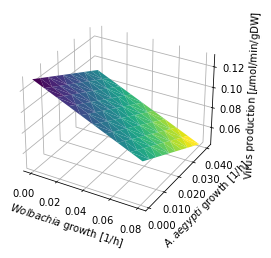

In [54]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.plot_trisurf(solW, solM, solV, cmap = plt.cm.viridis_r)#= plt.cm.Spectral)

ax.set_xlabel('$\it{Wolbachia}$ growth [1/h]')
ax.set_ylabel('$\it{A. aegypti}$ growth [1/h]')
ax.set_zlabel('Virus production [$\mu$mol/min/gDW]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


start, end = ax.get_ylim()

ax.yaxis.set_ticks(np.arange(0,end,0.01))


## Wolbachia artificial biomass analysis
Different _Wolbachia pipientis_ compositions defined for lipids, amino acids, nucleotides and others in order to test which one of these components is key for the pathogen blocking phenotype

In [55]:
biomassWLipids  = '0.00836 chsterol_w + 0.001751 pe140_w + 0.013972 pe160_w +  0.012628 pe161_w +  0.004119 pe180_w + 0.027998 pe181_w + 0.000621 pg140_w + 0.004942 pg160_w +  0.006254 pg161_w + 0.000484 pg180_w +  0.010596 pg181_w + 0.000169 ps140_w + 0.001005 ps160_w + 0.000908 ps161_w + 0.000295 ps180_w + 0.002005 ps181_w + 0.002277 clpn1_hs_w + 0.00112 clpn3_hs_w + 0.00219 clpn2_hs_w + 0.000621 pg140_w -> '#-> '#' + 0.000621 pg140_w -> '
biomassWAminoAcids = '0.219088 gln_L_w + 0.50987 gly_w + 0.427934 ala_L_w + 0.285438 lys_L_w + 0.200831 asn_L_w + 0.246697 arg_L_w + 0.219088 glu_L_w + 0.179456 ser_L_w + 0.127801 met_L_w + 0.047202 trp_L_w + 0.154519 phe_L_w + 0.120677 tyr_L_w + 0.076146 cys_L_w + 0.375389 leu_L_w +   0.079264 his_L_w + 0.184355 pro_L_w +  0.200831 asp_L_w + 0.352233 val_L_w + 0.211073 thr_L_w + 0.241799 ile_L_w + 55.350309 h2o_w -> '
biomassWNucleotides = '0.209121 gtp_w +  0.299774 ctp_w + 0.000223 thmpp_w + 0.140101 utp_w +  0.034997 datp_w +  0.016697 dctp_w + 0.016697 dgtp_w +  0.034997 dttp_w --> '
biomassWOthers = '0.001787 nad_w + 0.000223 10fthf_w + 0.000223 5mthf_w + 0.000279 accoa_w +  0.000223 amet_w +    0.00474 ca2_w + 0.00474 cl_w +    0.000168 coa_w + 0.00316 cobalt2_w +  0.00316 cu2_w +  5.5e-05 dtpcudcpp_w +  0.000223 fad_w + 0.007109 fe2_w + 0.007109 fe3_w +    0.000223 gthrd_w + 0.000223 hemeO_w +   0.177735 k_w + 3.1e-05 malcoa_w +  0.007899 mg2_w + 0.000223 mlthf_w + 0.00316 mn2_w +  4.5e-05 nadh_w + 0.000335 nadph_w + 0.011849 nh4_w +        0.000223 pheme_w +      0.03327 ptrc_w + 0.000223 pydx5p_w + 0.000223 q8_w + 0.000223 ribflv_w +  0.000223 sheme_w + 0.00395 so4_w + 0.006744 spmd_w + 9.8e-05 succoa_w + 0.000223 thf_w +     0.013381 uaagmda_w +   0.00316 zn2_w  ->'



In [56]:
#Required to "clean" reactions variables in case you are re-running this analysis
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))
model = setMedia(model)
#Reset constraint for Wolbachia growth
bioW = model.reactions.get_by_id('biomass_wolbachia')
bioW.lower_bound = 0
bioW.upper_bound = 0

cobra/core/model.py:727 UserWarning: bioWA not in symbiotic
cobra/core/model.py:727 UserWarning: bioWL not in symbiotic
cobra/core/model.py:727 UserWarning: bioWN not in symbiotic
cobra/core/model.py:727 UserWarning: bioWO not in symbiotic


In [57]:
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))
bioWL = Reaction('biomassWLipids')
bioWL.id = 'bioWL'
bioWL.name = 'Biomass Wolbachia only lipids'
bioWL.lower_bound = -1000
bioWL.upper_bound = 1000
model.add_reaction(bioWL)
model.reactions.bioWL.build_reaction_from_string(biomassWLipids,1)

cobra/core/model.py:727 UserWarning: bioWA not in symbiotic
cobra/core/model.py:727 UserWarning: bioWL not in symbiotic
cobra/core/model.py:727 UserWarning: bioWN not in symbiotic
cobra/core/model.py:727 UserWarning: bioWO not in symbiotic


In [58]:
##Solution Wolbachia lipid only biomass
wolBio = np.linspace(0.02,0.1,100)
bioWString = 'bioWL'
bioW = model.reactions.get_by_id(bioWString)
solmB = [] #biomass Wolbachia
solV = []
model.objective = 'ZIKV'

bioM = model.reactions.get_by_id('biomass_reaction')
bioM.lower_bound = 0.02
bioM.upper_bound = 0.02

for wB in wolBio:  
    bioW.lower_bound = wB
    bioW.upper_bound = wB
    try:
        sol = model.optimize()
        #print model.summary()
        if sol['ZIKV'] > 0:
        #if sol['biomass_reaction'] > 0:
            solmB.append(sol[bioWString])
            solV.append(sol['ZIKV'])
           
        else: 
            solmB.append(0)
            solV.append(0)
    except:
        print(wB)
        #solmB.append(-1)
        solV.append(-1)

##Solution Wolbachia lipid only biomass
solVWL = solV
solWL = solmB
bioW = model.reactions.get_by_id(bioWString)
bioW.lower_bound = 0
bioW.upper_bound = 0


In [59]:
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))
bioWA = Reaction('biomassWAminoAcids')
bioWA.id = 'bioWA'
bioWA.name = 'Biomass Wolbachia only AA'
bioWA.lower_bound = -1000
bioWA.upper_bound = 1000
model.add_reaction(bioWA)
model.reactions.bioWA.build_reaction_from_string(biomassWAminoAcids,1)

cobra/core/model.py:727 UserWarning: bioWA not in symbiotic
cobra/core/model.py:727 UserWarning: bioWN not in symbiotic
cobra/core/model.py:727 UserWarning: bioWO not in symbiotic


In [60]:
##Solution Wolbachia lipid only Aminoacids
wolBio = np.linspace(0.02,0.1,100)
#wolBio = np.linspace(0.02,0.06,100)
bioWString = 'bioWA'
bioW = model.reactions.get_by_id(bioWString)
solmB = [] #biomass Wolbachia
solV = []
model.objective = 'ZIKV'

bioM = model.reactions.get_by_id('biomass_reaction')
bioM.lower_bound = 0.02
bioM.upper_bound = 0.02

for wB in wolBio:  
    bioW.lower_bound = wB
    bioW.upper_bound = wB
    try:
        sol = model.optimize()
        #print model.summary()
        if sol['ZIKV'] > 0:
        #if sol['biomass_reaction'] > 0:
            solmB.append(sol[bioWString])
            solV.append(sol['ZIKV'])
           
        else: 
            solmB.append(0)
            solV.append(0)
    except:
        print(wB)
        #solmB.append(-1)
        solV.append(-1)

##Solution Wolbachia lipid only Aminoacids
solVWA = solV
solWA = solmB

bioW = model.reactions.get_by_id(bioWString)
bioW.lower_bound = 0
bioW.upper_bound = 0

In [61]:
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))
bioWN = Reaction('biomassWNucleotides')
bioWN.id = 'bioWN'
bioWN.name = 'Biomass Wolbachia only nucleotides'
bioWN.lower_bound = -1000
bioWN.upper_bound = 1000
model.add_reaction(bioWN)
model.reactions.bioWN.build_reaction_from_string(biomassWNucleotides,1)

cobra/core/model.py:727 UserWarning: bioWL not in symbiotic
cobra/core/model.py:727 UserWarning: bioWN not in symbiotic
cobra/core/model.py:727 UserWarning: bioWO not in symbiotic


In [62]:
##Solution Wolbachia only Nucleotides
wolBio = np.linspace(0.02,0.1,100)
bioWString = 'bioWN'
bioW = model.reactions.get_by_id(bioWString)
solmB = [] #biomass Wolbachia
solV = []
model.objective = 'ZIKV'

bioM = model.reactions.get_by_id('biomass_reaction')
bioM.lower_bound = 0.02
bioM.upper_bound = 0.02

for wB in wolBio:  
    bioW.lower_bound = wB
    bioW.upper_bound = wB
    try:
        sol = model.optimize()
        #print model.summary()
        if sol['ZIKV'] > 0:
            solmB.append(sol[bioWString])
            solV.append(sol['ZIKV'])
            #print sol['ZIKV']
        else: 
            solmB.append(sol[bioWString])
            solV.append(0)
    except:
        print(wB)
        #solmB.append(-1)
        solV.append(-1)

##Solution Wolbachia lipid only Nucleotides
solVWN = solV
solWN = solmB

bioW = model.reactions.get_by_id(bioWString)
bioW.lower_bound = 0
bioW.upper_bound = 0

In [63]:
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))
bioWO = Reaction('biomassWOthers')
bioWO.id = 'bioWO'
bioWO.name = 'Biomass Wolbachia Others'
bioWO.lower_bound = -1000
bioWO.upper_bound = 1000
model.add_reaction(bioWO)
model.reactions.bioWO.build_reaction_from_string(biomassWOthers,1)

cobra/core/model.py:727 UserWarning: bioWA not in symbiotic
cobra/core/model.py:727 UserWarning: bioWL not in symbiotic
cobra/core/model.py:727 UserWarning: bioWO not in symbiotic


In [64]:
##Solution Wolbachia only Others
wolBio = np.linspace(0.01,0.1,100)
bioWString = 'bioWO'
bioW = model.reactions.get_by_id(bioWString)
solmB = [] #biomass Wolbachia
solV = []
model.objective = 'ZIKV'

bioM = model.reactions.get_by_id('biomass_reaction')
bioM.lower_bound = 0.02
bioM.upper_bound = 0.02
for wB in wolBio:  
    bioW.lower_bound = wB
    bioW.upper_bound = wB

    sol = model.optimize()
    #print model.summary()
    solmB.append(sol[bioWString])
    solV.append(sol['ZIKV'])



##Solution Wolbachia only Others
solVWO = solV
solWO = solmB

bioW = model.reactions.get_by_id(bioWString)
bioW.lower_bound = 0
bioW.upper_bound = 0

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


In [65]:
model.remove_reactions(list(['bioWA', 'bioWL', 'bioWN', 'bioWO']))

cobra/core/model.py:727 UserWarning: bioWA not in symbiotic
cobra/core/model.py:727 UserWarning: bioWL not in symbiotic
cobra/core/model.py:727 UserWarning: bioWN not in symbiotic


In [68]:
#Define wolbachia minimum growth grid
wolBio = np.linspace(0.02,0.1,500)
bioW = model.reactions.get_by_id('biomass_wolbachia')
solmB = [] #biomass Wolbachia
solV = []
model.objective = 'ZIKV'

bioM = model.reactions.get_by_id('biomass_reaction')
bioM.lower_bound = 0.02
bioM.upper_bound = 0.02

for wB in wolBio:  
    bioW.lower_bound = wB
    bioW.upper_bound = wB
   
    try:
        sol = model.optimize()
        #print model.summary()
        if sol['ZIKV'] > 0:
        #if sol['biomass_reaction'] > 0:
            solmB.append(sol['biomass_wolbachia'])
            solV.append(sol['ZIKV'])
           
        else: 
            solmB.append(0)
            solV.append(0)
    except:
        #solmB = -1
        print(wB)
        #solmB.append(-1)
        solV.append(-1)

##Solution Wolbachia complete biomass
solVWC = solV
solWC = solmB

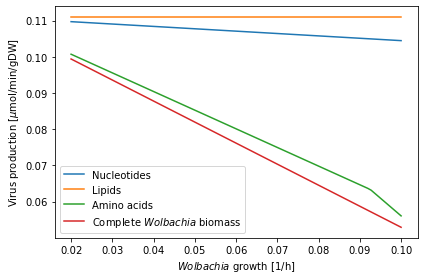

In [69]:
plt.plot(solWN,solVWN, label = 'Nucleotides')#', color ='#7f7f7f')
plt.plot(solWL,solVWL, label = 'Lipids')#, color='#e377c2')
plt.plot(solWA,solVWA, label='Amino acids')# ', color ='#17becf')
plt.plot(solWC,solVWC, label='Complete $\it{Wolbachia}$ biomass')#, color='#ff7f0e')



#plt.plot(solWO,solVWO)
plt.xlabel('$\it{Wolbachia}$ growth [1/h]')
plt.ylabel('Virus production [$\mu$mol/min/gDW]')
plt.legend()

plt.tight_layout()


#plt.savefig('pathogenBlockingBiomass.pdf')

## Generación sampling mosquito/Wolbachia
Para el gráfico se usan datos guardados de sampling

In [19]:
rxns = find_blocked_reactions(model)

for r in rxns:
    toDelete = model.reactions.get_by_id(r)
    toDelete.delete()